# Visualisation de données : Projet Chocolat

_Réalisée par Barbillon Héléna, Cordebar Benjamin, Hornberger Théo et Ménestrel Victor_


## Sommaire

* 0- Dataset
* 1- Initialisation
* 2- Est-ce que la notation des chocolats est bien répartie ?
* 3- Quels sont les pays producteurs de fèves de cacao ?
* 4- Quels sont les pays importateurs de fèves de cacao ?
* 5- Comment les gens apprécient-ils le chocolat ? Cela dépend-il des ingrédients ? Y a-t-il une évolution en fonction des années ?
* 6- Comment varie le goût du chocolat en fonction de sa teneur en cacao ? L’amertume du chocolat dépend-elle du pourcentage de cacao ?
* 7- A quoi pensent les gens quand ils mangent du chocolat ?
* 8- Quelles sont les caractéristiques gustatives préférées lors de la dégustation du chocolat ? Et celles moins appréciées ?

## 0 - La base de donnée utilisée

La dataset que nous avons utilisée est "Chocolate Ratings" disponible sur kaggle : https://www.kaggle.com/datasets/joebeachcapital/chocolate-ratings.
  
Cette base de donnée provient du site web "Flavors of Cacao" qui recense les résultats de dégustations de chocolat de la Manhattan's Chocolate Society depuis 2007. C'est un groupe de personnes se réunissant pour goûter, débattre sur les qualités gustatives et donner une note à des barres de chocolats.

Ces données comprennent des informations sur chaque chocolat évalué, tels que:
- le fabricant
- sa localisation
- la date d'évaluation
- l'origine des fèves de cacao
- le pourcentage de cacao
- les ingrédients
- les caractéristiques notables des barres de chocolat
- la note finale donnée

## 1- Initialisation

In [90]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from fuzzywuzzy import fuzz
import csv
import re

# Lecture des données
df = pd.read_csv('data/chocolate.csv')
df.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72%,"3- B,S,C","fatty, earthy, moss, nutty,chalky",3.00


Charte graphique

In [91]:
#Couleurs utilisées
palette = ['#874646', '#f6eddb', '#2b0808', '#6a4227', '#ffc0c0']
palette_degrade =['#71260A', '#96421D' ,'#C06530', '#DA8A56', '#E9D5CC']
background_color = "#fff7ef"
text_color = '#6f1c0e'

In [92]:
# informations sur les données
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ref                               2530 non-null   int64  
 1   company_manufacturer              2530 non-null   object 
 2   company_location                  2530 non-null   object 
 3   review_date                       2530 non-null   int64  
 4   country_of_bean_origin            2530 non-null   object 
 5   specific_bean_origin_or_bar_name  2530 non-null   object 
 6   cocoa_percent                     2530 non-null   object 
 7   ingredients                       2443 non-null   object 
 8   most_memorable_characteristics    2530 non-null   object 
 9   rating                            2530 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 197.8+ KB
None


In [93]:
# On vérifie qu'il ne manque pas de données
print(df.isnull().sum())
#il manque quelques données sur la colonne 'ingredients'

# On vérifie qu'il n'y a pas de doublons
print("\ndoublons:")
print(df.duplicated().sum())

ref                                  0
company_manufacturer                 0
company_location                     0
review_date                          0
country_of_bean_origin               0
specific_bean_origin_or_bar_name     0
cocoa_percent                        0
ingredients                         87
most_memorable_characteristics       0
rating                               0
dtype: int64

doublons:
0


In [94]:
# Transformer le pourcentage de cacao en données numériques (enlever le "%") 
df['cocoa_percent'] = df['cocoa_percent'].str.replace('%', '').astype(float)

## 2- Prise en main des données

#### Répartition des notes données

In [95]:
fig = px.violin(df, y='rating', title='Distribution des notes données aux chocolats', labels={'rating': 'Note'},
                width=500, height=300) 
fig.update_traces(box_visible=True, meanline_visible=True)
fig.update_traces(marker=dict(color=palette[0], line=dict(color='rgb(8,48,107)')))
fig.update_layout(plot_bgcolor=background_color, font_color=text_color,
                  margin=dict(l=40, r=20, t=50, b=10)) 
fig.show()

#### Répartition de la teneur en cacao des chocolats évalués

In [96]:
# Afficher la distribution de la teneur en cacao avec un boxplot
fig = px.violin(df, x='cocoa_percent', color_discrete_sequence=['#96421D'])

fig.update_layout(
    title="Distribution de la teneur en cacao des chocolats",
    yaxis_title="Teneur en cacao (%)",
    xaxis_title=None, # Masquer le titre de l'axe x
    plot_bgcolor=background_color,
    font_color=text_color,
    width=800, height=300
)
fig.show()

## 3- Contexte des dégustations: d'où viennent les chocolats?

### Origine de la matière première: les fèves de cacao

In [97]:
databis = df.copy()
#Selectionner les pays avec plus de 20 chocolats
databis['country_of_bean_origin'] = databis['country_of_bean_origin'].apply(lambda x: x if databis['country_of_bean_origin'].value_counts()[x] > 20 else 'Autres pays')
fig = px.histogram(databis, x='country_of_bean_origin', color_discrete_sequence=palette, title="Pays d'origine des fèves de cacao")
fig.update_xaxes(categoryorder='total descending', tickangle=45)
fig.update_layout(xaxis_title='', yaxis_title='Nombre de chocolats évalués')
fig.update_layout(plot_bgcolor=background_color, font_color=text_color)
fig.update_traces(marker=dict(color=palette[0]))
fig.show()

Les fèves de cacao des chocolats évalués proviennent principalement de pays d'Amérique du Sud. On note qu'un certain nombre des chocolats évalués proviennent de plusieurs pays différents (catégorie "Blend"), et nous avons aussi choisi de ne pas afficher les pays d'où viennent moins de 20 chocolats (catégorie "Autres pays").

In [98]:
fig=px.pie(df, names='country_of_bean_origin', title='Pays d\'origine des fèves de cacao', hole=0.4,color_discrete_sequence=px.colors.sequential.solar)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(margin=dict(l=40, r=20, t=50, b=10))
fig.update_layout(plot_bgcolor=palette[1], font_color=palette[2]) #couleurs

fig.show()

Nous avons choisi d'afficher tous les pays possibles sur ce diagramme pour pouvoir les voir à droite, même si c'est peu lisible sur le cercle.

In [99]:
tab=df['country_of_bean_origin'].value_counts()

# Origine des fèves de cacao par pays
fig = px.scatter_geo(tab, locations=tab.index, hover_name=tab.index, locationmode='country names', 
                     size=tab.values, title='Pays d\'origine des fèves de cacao' , color=tab.values, 
                     projection="natural earth", color_continuous_scale=palette_degrade)
#projection="orthographic"
fig.update_layout(margin=dict(l=40, r=20, t=50, b=10),coloraxis_colorbar=dict(title='Nombre de chocolats évalués'))
fig.update_traces(marker=dict(line=dict(width=1, color='Black')))
fig.update_layout(font_color=text_color)
fig.show()

La plupart des fèves de cacao des chocolats évalués sont importées d'Amérique latine, mais aussi d'Asie et d'Afrique.

### Où sont localisés les fabricants de chocolat ?

In [100]:
databis = df.copy()
databis['company_location'] = databis['company_location'].apply(lambda x: x if databis['company_location'].value_counts()[x] > 20 else 'Blend')

fig = px.histogram(databis[databis['company_location'] != 'Blend'], x='company_location', 
                   color_discrete_sequence=palette, title="Localisation des fabricants de chocolat parmis les chocolats évalués")
fig.update_xaxes(categoryorder='total descending', tickangle=45)
fig.update_layout(xaxis_title='Pays d\'origine des fèves de cacao', yaxis_title='Nombre de chocolats évalués')
fig.update_layout(plot_bgcolor=background_color, font_color=text_color)
fig.update_traces(marker=dict(color=palette[0]))
fig.show()

In [101]:
databis = df.copy()
#databis['company_location'] = databis['company_location'].apply(lambda x: x if databis['company_location'].value_counts()[x] > 30 else 'Autre pays')
fig=px.pie(databis, names='company_location', title='Pays importateurs de fèves de cacao', hole=0.4,color_discrete_sequence=px.colors.sequential.solar)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(margin=dict(l=40, r=20, t=50, b=10), showlegend=False)
fig.update_layout(plot_bgcolor=background_color, font_color=text_color)
fig.update_layout(width=500, height=500)
fig.show()

In [102]:
tab=df['company_location'].value_counts()

fig = px.scatter_geo(tab, locations=tab.index, hover_name=tab.index, locationmode='country names', size=tab.values,
                      title='Localisation des fabricants de chocolat' , color=tab.values, projection="natural earth", size_max=50,
                      color_continuous_scale=palette_degrade)
#projection="orthographic"
fig.update_layout(margin=dict(l=40, r=20, t=50, b=10),coloraxis_colorbar=dict(title='Nombre de chocolats évalués'))
fig.update_traces(marker=dict(line=dict(width=1, color='Black')))
fig.update_layout(font_color=text_color) #couleurs

fig.show()

Parmis les chocolats évalués par la Manhattan's Chocolate Society, la plupart étaient fabriqués aux Etats-Unis, et les fèves importées de pays d'Amérique latine, d'Afrique ou d'Asie.

In [103]:
with open('data/country-capital.csv', 'r') as f:
    reader = csv.reader(f)
    dataCountry = list(reader)

#permet de récupérer les coordonnées de la capitale d'un pays à partir du fichier country-capital.csv
def get_coordinates(country):
    for row in dataCountry:
        if row[0] == country:
            return row[2], row[3]
    return 0, 0

#permet de récupérer le nom du pays à partir de coordonnées
def get_country(lat,lon):
    for row in dataCountry:
        if row[2] == lat and row[3]==lon:
            return row[0]
    return None

#Enregistrement du dataframe avec les coordonnées dans un nouveau fichier
#data.to_csv('data/chocolate_with_coordinates.csv', index=False)

coord_USA = (38.8951, -77.0364)
data=df.copy()
data['coord_origine'] = data['country_of_bean_origin'].apply(get_coordinates)
data['coord_arrivee'] = data['company_location'].apply(get_coordinates)

#chocolats qui viennent des USA
dataTest = data[data['company_location']== 'U.S.A.']

#enlève les coordonnees vides
dataTest = dataTest[dataTest['coord_origine']!= (0,0)]

x=dataTest['coord_origine'].value_counts()

lat=[]
lon=[]
nom=[]
qtt=[]

#alterne les coordonnées du pays d'importation et des USA
for i in range(0,len(x)):
    #print(i)
    #print(x.index[i])
    lat.append(x.index[i][0])
    lon.append(x.index[i][1])
    pays=get_country(x.index[i][0],x.index[i][1])
    nom.append(pays)
    qtt.append(str(x.values[i]))
    lat.append(coord_USA[0])
    lon.append(coord_USA[1])
    nom.append("USA")
    qtt.append("")

 
fig = px.line_geo(lat=lat, lon=lon, title='Trajet effectué par les fèves de cacao importées vers les USA', 
                  projection="orthographic", hover_name=nom)
fig.update_layout(margin=dict(l=40, r=20, t=50, b=10))
fig.show()

## 4 - Caractères gustatifs du chocolat 
#### Lien entre la note attribuée et la teneur en cacao

In [104]:
import plotly.graph_objects as go
average_rating = data.groupby('cocoa_percent')['rating'].mean().reset_index()
median_rating = data.groupby('cocoa_percent')['rating'].median().reset_index()
min_rating = data.groupby('cocoa_percent')['rating'].min().reset_index()
max_rating = data.groupby('cocoa_percent')['rating'].max().reset_index()

fig = go.Figure()
fig.add_scatter(x=max_rating['cocoa_percent'], y=max_rating['rating'], mode='lines', name='max', line=dict(color=palette_degrade[4]))
fig.add_scatter(x=min_rating['cocoa_percent'], y=min_rating['rating'], mode='lines', name='min', fill='tonexty', line=dict(color=palette_degrade[4]))

fig.add_scatter(x=average_rating['cocoa_percent'], y=average_rating['rating'], mode='lines+markers', name='note moyenne', line=dict(color=palette[0]))
fig.update_layout(xaxis_title='Teneur en cacao (en %)', yaxis_title='Note')
fig.update_layout(plot_bgcolor=background_color, font_color=text_color)
fig.update_layout(margin=dict(l=40, r=20, t=50, b=10))
fig.update_layout(title='Répartition des notes en fonction de la teneur en cacao')
fig.show()

On peut affirmer qu'au-delà de 90% de cacao, le chocolat est généralement moins apprécié, mais que la teneur en cacao n'est pas une caractéristique déterminant la qualité du chocolat.

####  Est-ce que les notes dépendent des ingrédients ? Y a-t-il une évolution en fonction des années ?

Tout d'abord nous vérifions l'état de la base de données, notamment, nous vérifions qu'il ne manque pas de données importantes. \
Nous avons trouvé précédement que pour 87 lignes sur 2530, le champ "ingrédient" n'était pas rempli. Ces lignes représentant moins de 0,5% des données, ous choisissons de les supprimer de la table.

In [105]:
print(f"Nombre de lignes avant suppression: {df.shape[0]}")
data_cleaned = df.dropna(subset=['ingredients'])
print(f"Nombre de lignes après suppression: {data_cleaned.shape[0]}")

Nombre de lignes avant suppression: 2530
Nombre de lignes après suppression: 2443


Nous voulons étudier les ingrédients et leur nombre. C'est pourquoi nous allons modifier la dataframe. Nous ajoutons des colonnes pour tranformer les données "ingrédients" en format binaire. 

In [106]:
# Décoder les ingrédients
ingredients = {
    'B': 'Beans',
    'S': 'Sugar',
    'S*': 'Sweetener other than sugar',
    'C': 'Cocoa Butter',
    'V': 'Vanilla',
    'L': 'Lecithin',
    'Sa': 'Salt'
}

# Créer une copie indépendante pour éviter les avertissements lors de la modification
data_cleaned2 = data.dropna(subset=['ingredients']).copy()

for ingredient, full_name in ingredients.items():
    data_cleaned2[full_name] = data_cleaned2['ingredients'].apply(lambda x: 1 if ingredient in x else 0)

data_cleaned2.head(3)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,coord_origine,coord_arrivee,Beans,Sugar,Sweetener other than sugar,Cocoa Butter,Vanilla,Lecithin,Salt
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,"(-6.1722, 35.7395)","(38.8951, -77.0364)",1,1,0,1,0,0,0
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"(18.4896, -69.9018)","(38.8951, -77.0364)",1,1,0,1,0,0,0
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"(-18.9137, 47.5361)","(38.8951, -77.0364)",1,1,0,1,0,0,0


Pour calculer le nombre moyen d'ingrédients nous allons également modifier la dataframe en ajoutant une colonnes correspondant à ce dernier.  

In [107]:
#Nous allons ajouter une nouvelle colonne qui compte le nombre d'ingrédients pour chaque chocolat
data_cleaned2['Num_Ingredients'] = data_cleaned2[['Beans', 'Sugar', 'Sweetener other than sugar', 'Cocoa Butter', 'Vanilla', 'Lecithin', 'Salt']].sum(axis=1)

data_cleaned2.head(3)


,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,coord_origine,coord_arrivee,Beans,Sugar,Sweetener other than sugar,Cocoa Butter,Vanilla,Lecithin,Salt,Num_Ingredients
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,"(-6.1722, 35.7395)","(38.8951, -77.0364)",1,1,0,1,0,0,0,3
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,"(18.4896, -69.9018)","(38.8951, -77.0364)",1,1,0,1,0,0,0,3
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,"(-18.9137, 47.5361)","(38.8951, -77.0364)",1,1,0,1,0,0,0,3


Nous allons étudier l'évolution du nombre d'ingrédients par chocolat en fonction du temps (années).

In [108]:
# Grouper par année ('review_date') et calculer la moyenne du nombre d'ingrédients et la moyenne des notes
average_values_per_year = data_cleaned2.groupby('review_date').agg({'Num_Ingredients': 'mean', 'rating': 'mean'}).reset_index()

# Renommer les colonnes pour plus de clarté
average_values_per_year.rename(columns={'Num_Ingredients': 'Average_Ingredients', 'rating': 'Average_Rating'}, inplace=True)

# Créer un graphique linéaire pour visualiser l'évolution du nombre d'ingrédients par année
fig = px.line(average_values_per_year, x='review_date', y='Average_Ingredients', title='Évolution du nombre d\'ingrédients par année',
              labels={'review_date': 'Année', 'Average_Ingredients': 'Nombre d\'ingrédients'}, color_discrete_sequence=['#6a4227'])
fig.update_layout(plot_bgcolor=background_color, font_color=text_color)
fig.show()

Nous allons étudier l'évolution de la note moyenne des chocolats en fonction du temps (années).

In [109]:
data_grouped = data_cleaned.copy()

data_grouped = data_cleaned.groupby('review_date')['rating'].mean().reset_index()

# Créer un graphique linéaire avec Plotly
fig = px.line(data_grouped, x='review_date', y='rating', title='Évolution moyenne des notes par année',
              labels={'review_date': 'Année', 'rating': 'Note moyenne'},color_discrete_sequence=['#6a4227'])

fig.update_layout(plot_bgcolor=background_color, font_color=text_color)

# Afficher le graphique
fig.show()

 Conclusion intermédiare : cela nous fait penser à une possible corrélation entre la note moyenne des chocolats et leur nombre d'ingrédients. Nous allons, alors, effectuer une matrice de corrélation entre la note moyenne et le nombre d'ingrédients des chocolats.

In [110]:
# Calculer la matrice de corrélation
correlation_matrix = average_values_per_year[['Average_Ingredients', 'Average_Rating']].corr()

# Renommage des colonnes dans la matrice de corrélation pour des étiquettes plus descriptives
correlation_matrix = correlation_matrix.rename(index={'Average_Ingredients': 'Nombre moyen d\'ingrédients', 'Average_Rating': 'Note Moyenne'},
                                               columns={'Average_Ingredients': 'Nombre moyen d\'ingrédients', 'Average_Rating': 'Note Moyenne'})
# Définir une échelle de couleurs personnalisée en marron
brown_scale = [
    [0, 'rgb(255,248,220)'],  # Cornsilk color
    [0.5, 'rgb(210,180,140)'],  # Tan color
    [1, '#96421D']  # Brown color
]
# imshow avec plotly
fig = px.imshow(correlation_matrix, color_continuous_scale=brown_scale,text_auto=True,
                title='Matrice de corrélation entre le nombre d\'ingrédients et la note moyenne')
# Mise à jour du titre et de l'étiquette de la barre de couleurs
fig.update_layout(
    coloraxis_colorbar=dict(
        title='Coefficient de corrélation de Pearson',
    )
)
fig.show()

 Conclusion partielle : les personnes attribuent des notes de plus en plus élevées, ce qui peut suggérer que les chocolats deviennent de plus en plus savoureux ou que les gens deviennent plus généreux dans leurs évaluations. Par ailleurs, nous avons remarqué une bonne corrélation inverse (-75%) entre le nombre d'ingrédients et la note moyenne des chocolats. Attention, néanmoins, la corrélation n'implique par la causalité, mais cette dernière pourrait expliquer certaines choses.

## 6- Comment varie le goût du chocolat en fonction de sa teneur en cacao ? L’amertume du chocolat dépend-elle du pourcentage de cacao ?

### Prétraitement
Il faut premièrement convertir les poucentages de cacao en format float. Et convertir les carcatéristiques sous formes de listes pour pouvoir les traiter séparement.

In [111]:
dataframe = df.copy()
# Séparer les caractéristiques les plus mémorables en listes
dataframe['most_memorable_characteristics'] = dataframe['most_memorable_characteristics'].str.split(', ')
dataframe.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","[rich cocoa, fatty, bready]",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","[cocoa, vegetal, savory]",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","[cocoa, blackberry, full body]",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68.0,"3- B,S,C","[chewy, off, rubbery]",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72.0,"3- B,S,C","[fatty, earthy, moss, nutty,chalky]",3.00


### Traitement

In [112]:
# Créer un dictionnaire pour stocker les associations caractéristiques les plus mémorables - pourcentages de cacao
association_caracteristique_cacao = {}

# Faire une boucle sur chaque ligne du DataFrame
for index, row in dataframe.iterrows():
    pourcentage_cacao = row['cocoa_percent']
    # Afficher les valeurs de chaque colonne pour la ligne actuelle
    for i in row['most_memorable_characteristics']:
        if i in association_caracteristique_cacao:
            # Ajouter le pourcentage de cacao à la liste existante
            association_caracteristique_cacao[i].append(pourcentage_cacao)
        else:
            # Créer une nouvelle liste avec le pourcentage de cacao pour cette caractéristique
            association_caracteristique_cacao[i] = [pourcentage_cacao]

# Afficher le dictionnaire résultant
print(association_caracteristique_cacao)

{'rich cocoa': [76.0, 66.0, 68.0, 70.0, 73.0, 70.0, 71.0, 75.0, 70.0, 72.0, 77.0, 74.0, 68.0, 73.0, 75.0, 70.0, 66.0, 66.0, 72.0, 70.0, 70.0, 70.0, 61.0, 72.0, 70.0, 68.0, 68.0, 69.0, 70.0, 75.0, 75.0, 70.0, 68.0, 85.0, 72.0, 80.0, 70.0, 68.0, 72.0, 72.0, 70.0, 70.0, 75.0, 75.0, 72.0, 75.0, 75.0, 70.0, 73.0, 70.0, 64.0, 66.0, 70.0], 'fatty': [76.0, 72.0, 80.0, 75.0, 75.0, 85.0, 63.0, 70.0, 75.0, 72.0, 72.0, 82.0, 72.0, 72.0, 70.0, 70.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 80.0, 68.0, 70.0, 82.0, 70.0, 100.0, 72.0, 73.0, 70.0, 70.0, 70.0, 80.0, 72.0, 70.0, 70.0, 70.0, 72.0, 75.0, 82.0, 72.0, 75.0, 70.0, 70.0, 70.0, 66.0, 80.0, 75.0, 72.0, 82.0, 70.0, 76.0, 72.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 77.0, 68.0, 75.0, 72.0, 71.0, 61.0, 91.0, 70.0, 70.0, 72.0, 71.0, 71.0, 71.0, 70.0, 70.0, 70.0, 72.0, 72.0, 80.0, 70.0, 70.0, 72.0, 72.0, 75.0, 70.0, 72.0, 70.0, 70.0, 75.0, 75.0, 72.0, 74.0, 68.0, 68.0, 75.0, 72.0, 75.0, 70.0, 70.0, 72.0, 80.0, 75.0, 75.0, 89.0, 70.0, 80.0, 70.0, 

In [113]:
# Trier le dictionnaire en fonction de la longueur des listes de pourcentages de cacao
association_caracteristique_cacao_trie = dict(sorted(association_caracteristique_cacao.items(), key=lambda item: len(item[1]), reverse=False))

# Filtrer les caractéristiques pour ne garder que celles avec plus de 10 valeurs (n>=10)
association_caracteristique_cacao_filtre = {caractere: pourcentages for caractere, pourcentages in association_caracteristique_cacao_trie.items() if len(pourcentages) >= 10}

# Afficher le dictionnaire filtré
for caractere, pourcentages in association_caracteristique_cacao_filtre.items():
    print(f"Caractéristique '{caractere}': {len(pourcentages)} valeurs")


Caractéristique 'long': 10 valeurs
Caractéristique 'very sweet': 10 valeurs
Caractéristique 'raisin': 10 valeurs
Caractéristique 'buttery': 10 valeurs
Caractéristique 'leathery': 10 valeurs
Caractéristique 'blackberry': 11 valeurs
Caractéristique 'light color': 11 valeurs
Caractéristique 'musty': 11 valeurs
Caractéristique 'ashey': 11 valeurs
Caractéristique 'cinamon': 11 valeurs
Caractéristique 'high roast': 11 valeurs
Caractéristique 'mild smoke': 11 valeurs
Caractéristique 'bourbon': 11 valeurs
Caractéristique 'peanut butter': 11 valeurs
Caractéristique 'strong vanilla': 11 valeurs
Caractéristique 'sweet edge': 11 valeurs
Caractéristique 'mild': 11 valeurs
Caractéristique 'leather': 12 valeurs
Caractéristique 'delicate': 12 valeurs
Caractéristique 'tea': 12 valeurs
Caractéristique 'grape': 12 valeurs
Caractéristique 'perfume': 12 valeurs
Caractéristique 'savory': 13 valeurs
Caractéristique 'raspberry': 13 valeurs
Caractéristique 'waxy': 13 valeurs
Caractéristique 'mint': 13 valeurs


In [114]:
# Initialiser un dictionnaire pour stocker les moyennes
moyennes_caracteristiques = {}

# Calculer la moyenne pour chaque caractéristique
for caractere, pourcentages in association_caracteristique_cacao_filtre.items():
    moyenne = sum(pourcentages) / len(pourcentages)
    moyennes_caracteristiques[caractere] = moyenne

# Afficher les moyennes
for caractere, moyenne in moyennes_caracteristiques.items():
    print(f"Moyenne pour la caractéristique '{caractere}': {moyenne}")

Moyenne pour la caractéristique 'long': 71.3
Moyenne pour la caractéristique 'very sweet': 55.85
Moyenne pour la caractéristique 'raisin': 71.9
Moyenne pour la caractéristique 'buttery': 73.2
Moyenne pour la caractéristique 'leathery': 74.0
Moyenne pour la caractéristique 'blackberry': 71.54545454545455
Moyenne pour la caractéristique 'light color': 71.0
Moyenne pour la caractéristique 'musty': 74.81818181818181
Moyenne pour la caractéristique 'ashey': 74.54545454545455
Moyenne pour la caractéristique 'cinamon': 73.72727272727273
Moyenne pour la caractéristique 'high roast': 72.0909090909091
Moyenne pour la caractéristique 'mild smoke': 72.27272727272727
Moyenne pour la caractéristique 'bourbon': 75.95454545454545
Moyenne pour la caractéristique 'peanut butter': 70.18181818181819
Moyenne pour la caractéristique 'strong vanilla': 71.0909090909091
Moyenne pour la caractéristique 'sweet edge': 72.0
Moyenne pour la caractéristique 'mild': 71.0
Moyenne pour la caractéristique 'leather': 71.

In [115]:
# Créer un DataFrame à partir du dictionnaire de moyennes
df_moyennes = pd.DataFrame(list(moyennes_caracteristiques.items()), columns=['Caractéristique', 'Pourcentage moyen de cacao'])

# Trier le DataFrame dans l'ordre décroissant selon la colonne 'Pourcentage moyen de cacao'
df_moyennes = df_moyennes.sort_values(by='Pourcentage moyen de cacao', ascending=False)

# Créer un graphique avec Plotly Express
fig = px.scatter(df_moyennes, x='Caractéristique', y='Pourcentage moyen de cacao', title='Pourcentage moyen de cacao associé à chaque caractéristique',color_discrete_sequence=['#96421D'])

# Afficher le graphique
fig.update_layout(plot_bgcolor=background_color, font_color=text_color)
fig.show()

Conclusion intermédiare : Sur les caractéristiques référencées 10 fois au minimum, il semblerait qu'il n'y ai généralement pas une corrélation très significative du pourcentage de cacao sur les caractérsitiques, à l'exception des extrèmes, soit un chocolat amère et un chocolat très sucré.

In [116]:
import plotly.graph_objects as go

# Création des labels et des valeurs
labels = ['bitter', 'very sweet']
values = [moyennes_caracteristiques[label] for label in labels]

# Arrondir les pourcentages et les formater avec le symbole "%"
formatted_values = [f"{round(val)}%" for val in values]

# Création du graphique à barres
fig = go.Figure(data=[go.Bar(x=['Amère', 'Très sucré'], y=values, 
                             text=formatted_values,
                             textposition='auto',
                             marker=dict(color=['#2b0808', '#ffc0c0']))])

# Mise en forme du layout
fig.update_layout(title='Pourcentage moyen de cacao en fonction des goûts ressentis',
                  xaxis_title='Goûts',
                  yaxis_title='Pourcentage moyen de cacao',plot_bgcolor=background_color, font_color=text_color)

# Afficher le graphique
fig.show()


Avec ces différents graphiques on peut conclure 2 choses. La première c'est que les caractéristiques gustatives du chocolat ne sont généralement pas corrélés avec sa teneur en cacao : une grand majorité de ces caractéristiques se situent entre 69% et 75% de teneur en cacao. Cependant, on peut aussi conclure que les caractéristiques ne suivant pas cette tendance décrivent l'amertume du chocolat. En effet, un chocolat très fort en cacao (>80%) sera souvant décrit comme amère alors qu'un chocolat faible en cacao (<60%) sera décrit comme sucré car l'ingrédient est présent en plus grande quantité.

## 7- A quoi pensent les gens quand ils mangent du chocolat ?

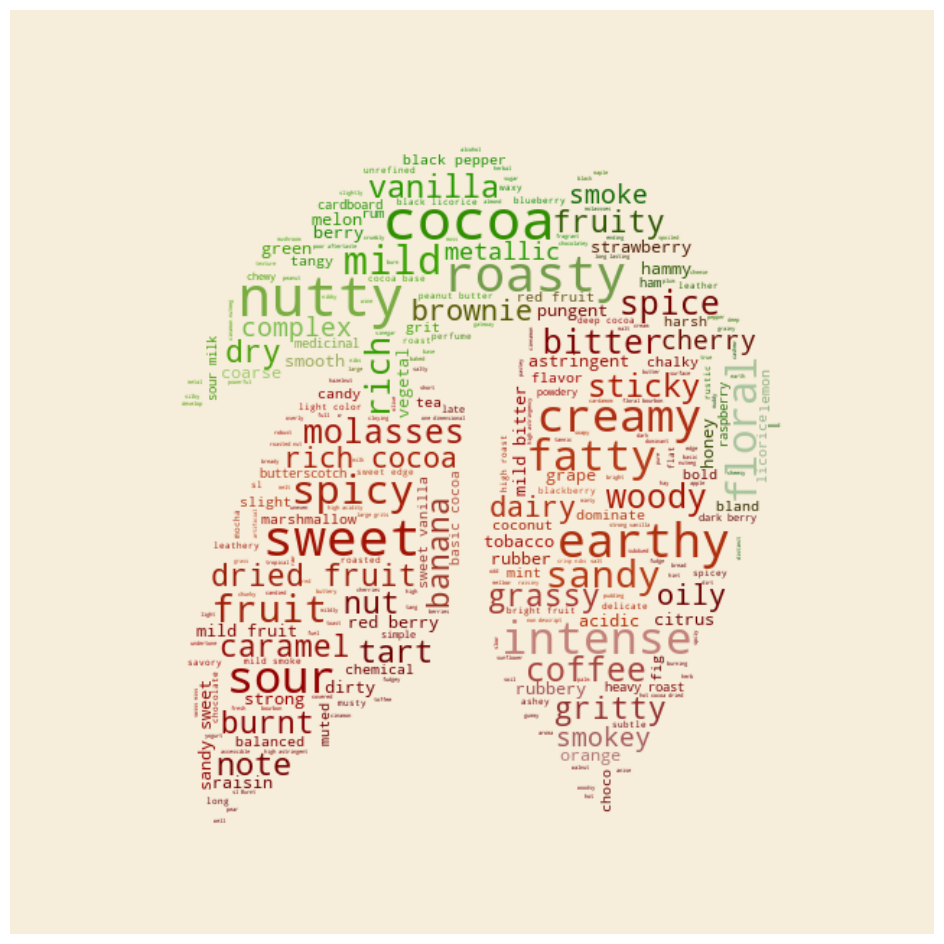

In [117]:
choco_color = np.array(Image.open("img/cacao.jpg"))
choco_color = choco_color[::3, ::3]

# create mask of the image without the white background
choco_mask = choco_color.copy()
choco_mask[choco_mask.sum(axis=2) == 0] = 255

# we do edges detection to accentuate the edges
edges = np.mean([gaussian_gradient_magnitude(choco_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
choco_mask[edges > .08] = 255

wc = WordCloud(max_words=2000, mask=choco_mask, max_font_size=40, random_state=42, background_color='#f6eddb')

# generate word cloud
wc.generate(' '.join(data['most_memorable_characteristics']))

# create coloring from image
image_colors = ImageColorGenerator(choco_color)
wc.recolor(color_func=image_colors)

plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')

# Save the image with higher resolution (dpi)
plt.show()


## 8- Quelles sont les caractéristiques gustatives préférées lors de la dégustation du chocolat ? Et celles moins appréciées ?

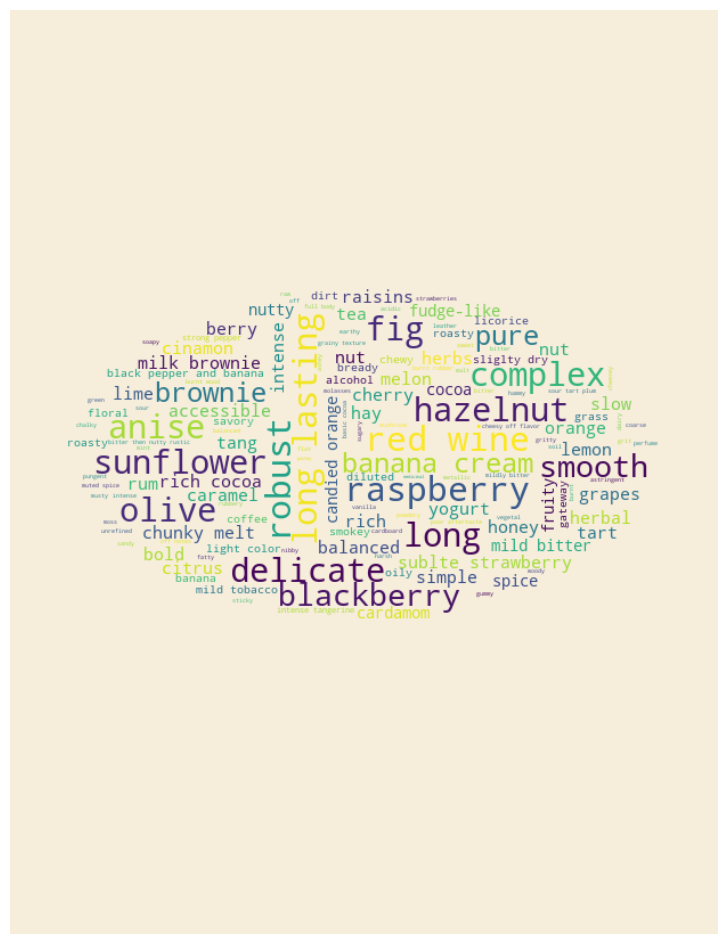

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from fuzzywuzzy import fuzz

# Read the data
data = pd.read_csv('data/chocolate.csv')

# Function to merge similar characteristics
def merge_similar_characteristics(characteristics):
    merged = {}
    for char in characteristics:
        merged[char] = char
        for key in merged.keys():
            if char != key and fuzz.partial_ratio(char, key) >= 80:
                merged[char] = key
                break
    return merged

# Split multiple characteristics and explode into separate rows
data['most_memorable_characteristics'] = data['most_memorable_characteristics'].str.split(',')
data = data.explode('most_memorable_characteristics')

# Merge similar characteristics
similar_characteristics = merge_similar_characteristics(data['most_memorable_characteristics'].unique())
data['most_memorable_characteristics'] = data['most_memorable_characteristics'].map(similar_characteristics)

# Remove characteristics with less than 3 occurrences
data = data.groupby('most_memorable_characteristics').filter(lambda x: len(x) > 3)

# Calculate average rating for each characteristic
average_rating = data.groupby('most_memorable_characteristics')['rating'].mean().to_dict()

# Normalize ratings to range from 0 to 1
min_rating = min(average_rating.values())
max_rating = max(average_rating.values())
normalized_ratings = {word: (rating - min_rating) / (max_rating - min_rating) for word, rating in average_rating.items()}

mask = np.array(Image.open("img/ellipse.png"))

wc = WordCloud(max_words=2000, max_font_size=30, mask=mask, random_state=41,background_color='#f6eddb',colormap='viridis')

wc.generate_from_frequencies(normalized_ratings)

plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

(-0.5, 620.5, 810.5, -0.5)

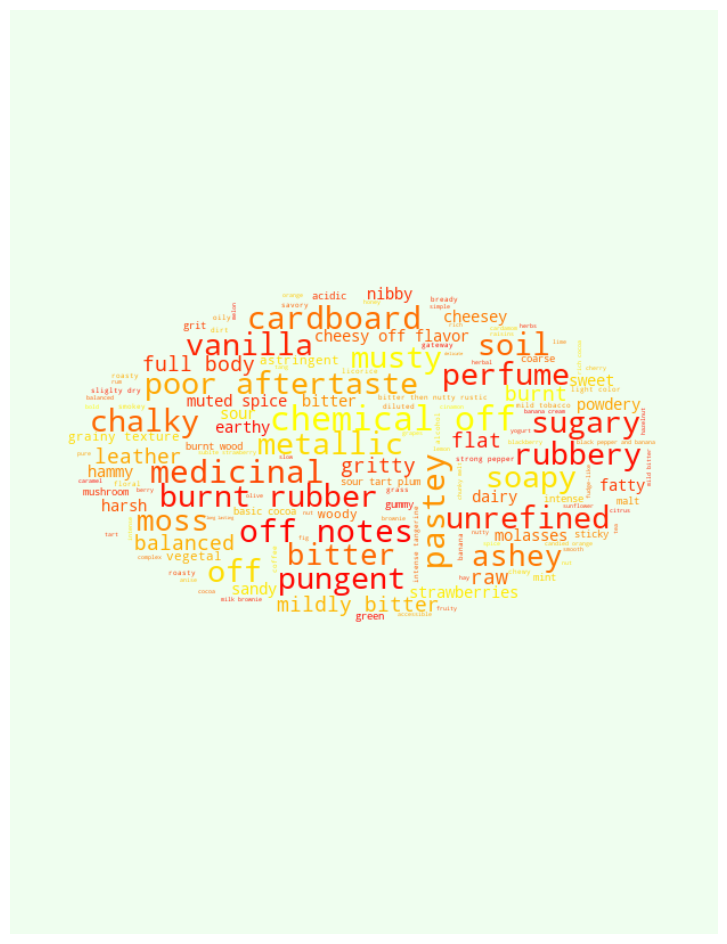

In [119]:
# we invert max/min values to get the opposite result
min_rating = max(average_rating.values())
max_rating = min(average_rating.values())
normalized_ratings = {word: (rating - min_rating) / (max_rating - min_rating) for word, rating in average_rating.items()}

mask = np.array(Image.open("img/ellipse.png"))

wc = WordCloud(max_words=2000, max_font_size=30, mask=mask, random_state=41,background_color='#effeef',colormap='autumn')

wc.generate_from_frequencies(normalized_ratings)

plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')